In [1]:
%cd /content/drive/MyDrive/ML/Intent Classification

/content/drive/MyDrive/ML/Intent Classification


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn.model_selection import train_test_split
from nltk import *
from keras.preprocessing.text import Tokenizer

In [3]:
df = pd.read_csv('final_data_v2.csv')

In [4]:
df

,Unnamed: 0,Unnamed: 0.1,sentence,intents,clean_sentence
0,0,0,what alarms do i have set right now,alarm_query,alarm set right
1,1,1,checkout today alarm of meeting,alarm_query,checkout today alarm meet
2,2,2,report alarm settings,alarm_query,report alarm set
3,3,3,see see for me the alarms that you have set to...,alarm_query,see see alarm set tomorrow morn
4,4,4,is there an alarm for ten am,alarm_query,alarm ten
...,...,...,...,...,...
8649,8649,8649,how hot is it in miami,weather_query,hot mimi
8650,8650,8650,will it snow next week,weather_query,snow next week
8651,8651,8651,am i gonna need rain boots,weather_query,donna need rain boot
8652,8652,8652,should i bring warm clothes,weather_query,bring warm cloth


In [5]:
len(df['intents'].unique())
len(df['clean_sentence'])

8654

In [10]:
import re
for i in range(len(df['clean_sentence'] )):
  df['clean_sentence'][i] = re.sub(r'[0-9]+', '',str(df['clean_sentence'][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
text = df['clean_sentence']
labels = df['intents']

In [12]:
train_txt,test_txt,train_label,test_labels = train_test_split(text,labels,test_size = 0.3)

In [13]:
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))

In [14]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=9def46020834b6dbb4d2765669745b418fbc5378ac882e0266696afea5b34e55
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [17]:
import wget
url = 'https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

'glove.6B.100d.txt'

In [18]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [19]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [20]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.004451992, 0.4081574)

In [21]:
max_num_words = 40000
embedding_dim=len(embeddings_index['the'])
classes = np.unique(df['intents'])

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)

train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen, padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')
word_index = tokenizer.word_index

In [22]:
num_words = min(max_num_words, len(word_index) )+1
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [24]:
train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)

In [25]:
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

In [26]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding

In [27]:
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 100)            256700    
_________________________________________________________________
bidirectional (Bidirectional (None, 8, 512)            731136    
_________________________________________________________________
dropout (Dropout)            (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                12850     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [29]:
history = model.fit(train_sequences, train_label, epochs = 20,
          batch_size = 64, shuffle=True,
          validation_data=[test_sequences, test_labels])

Epoch 1/20
95/95 [==============================] - 41s 323ms/step - loss: 3.4145 - acc: 0.1289 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/20
95/95 [==============================] - 30s 314ms/step - loss: 2.1185 - acc: 0.4142 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/20
95/95 [==============================] - 30s 314ms/step - loss: 1.5681 - acc: 0.5537 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/20
95/95 [==============================] - 30s 315ms/step - loss: 1.2809 - acc: 0.6401 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/20
95/95 [==============================] - 30s 316ms/step - loss: 1.1118 - acc: 0.6952 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 6/20
95/95 [==============================] - 30s 317ms/step - loss: 0.9694 - acc: 0.7266 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 7/20
95/95 [==============================] - 30s 318ms/step - loss: 0.8591 - acc: 0.7581 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 8/20
95

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

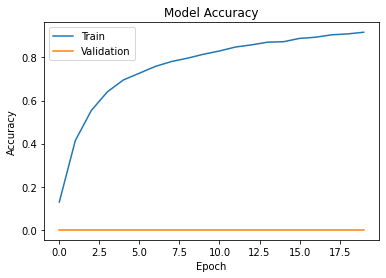

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

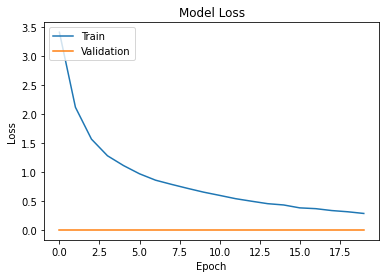

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
model.save('/content/drive/MyDrive/ML/Intent Classification/model/model.h5')

In [46]:
import pickle
with open('/content/drive/MyDrive/ML/Intent Classification/model/tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('/content/drive/MyDrive/ML/Intent Classification/model/classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open('/content/drive/MyDrive/ML/Intent Classification/model/label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

In [47]:
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        return label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [48]:
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)

In [52]:
text = input("enter your text to find intent: ")
intent = nlu.get_intent(text)
print(intent)

enter your text to find intent: set alarm on 6am
alarm_set
